# **SETUP: Markov Class, Diab2Lifes(Markov) and define models**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

def Qx(gender,x,t,param =[]): #Mortality incl trend
  if gender == 0:
    a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
  else:
    a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
  return(min(1,max(0,np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))))

def QxNoTrend(gender,x,t,param =[]): #Mortality no trend
    return(Qx(gender,x,2024,param =param))

def Ix(gender,x,t,param =[]): #Diability incidence rate (here independent of gender)
    return(min(0.25,max(0,0.0004+10**(0.06*x-5.46))))

def Rx(gender,x,t,param =[]):
    dFact = min(1,max(0., 1 - (x-30)/55.))
    if t == 0: return(0.30*dFact)
    if t == 1: return(0.08*dFact)
    if t == 2: return(0.04*dFact)
    if t > 2: return(0.5*Rx(gender,x,t-1))
    return(0.0)

In [247]:
class Markov:
    def __init__(self):
        self.iNrStates = None
        self.iMaxTime  = None
        self.dPij = [] # for each time a matrix ie dPij[k] matrix at time k
        self.dPre = [] # Vector vector of annuities at time t
        self.dPost= []
        self.dv   = []
        # Outputs
        self.dDK  = []
        self.dDKDistr  = []
        self.dCF  = []
        self.bCalculated = False
        self.bCFCalculated = False
        self.bCalculatedDistr = False
        self.iStart = None
        self.iStop  = None
        self.fDistrLow = -1000
        self.fDistrHigh = 150000
        self.iNrBuckets = 10000
        self.fBucketWidth = (self.fDistrHigh-self.fDistrLow)/self.iNrBuckets
        self.fBucketWidthRound = self.fBucketWidth / 2.

    def vDefineModel(self,iNrStates,iMaxTime=1200):
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        for i in range(iMaxTime):
            tempPij = np.zeros([iNrStates,iNrStates])
            tempPost = np.zeros([iNrStates,iNrStates])
            tempPre = np.zeros([iNrStates])
            tempDK = np.zeros([iNrStates])
            tempCF = np.zeros([iNrStates])
            self.dPij.append(tempPij)
            self.dPost.append(tempPost)
            self.dPre.append(tempPre)
            self.dDK.append(tempDK)
            self.dCF.append(tempCF)
        tempv = np.zeros([iMaxTime])
        self.dv=tempv

    def iBucketNr(self, fValue):
        if fValue < self.fDistrLow:
            return(0)
        iBNR = (int(min(self.iNrBuckets-1,(fValue-self.fDistrLow)/self.fBucketWidth+self.fBucketWidthRound)))
        return(iBNR)

    def fValueOfBucket(self, iBucket):
        return(self.fBucketWidth*min(self.iNrBuckets-1,iBucket)+self.fDistrLow)

    def vCreateDistModel(self):
        print("You Know that you can call me only once everything is done")
        for i in range(self.iMaxTime):
            tempDK = np.zeros([self.iNrStates,self.iNrBuckets])
            self.dDKDistr.append(tempDK)

    def vSetDiscount(self,fIRate):# you set v
        vTemp = 1./(1.+fIRate)
        for i in range(self.iMaxTime):
            self.dv[i] = vTemp
        self.bCalculated = False
        self.bCFCalculated = False

    def vSetPij(self,t,i,j,fValue):# you set p_{ij}(t,t+1)
        self.dPij[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False

    def vSetPre(self,t,i,j,fValue):# you set a_{i}^{pre}(t)
        self.dPre[t][i] = fValue
        self.bCalculated = False
        self.bCFCalculated = False

    def vSetPost(self,t,i,j,fValue):# you set a_{ij}^{post}(t)
        self.dPost[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False

    def doComplementStates(self,default=None, eps = 0.0001):
        iState = self.iNrStates -1
        if default != None:
            iState = default
        for i in range(self.iNrStates):
            bFound = False
            for t in range(self.iStop,self.iStart):
                fTot = sum(self.dPij[t][i,:])
                #print(i,t,"-->",fTot)
                if abs(fTot-1.) >= eps:
                    bFound=True
                    self.dPij[t][i,default] += 1. - fTot
            if bFound:
                print("Check P(Omega) = 1 failed for iState=",i,"Target State",iState)


    def doCalculateDK(self,iStart,iStop,iAge,iState):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.

        for i in range(self.iStart-1, self.iStop-1,-1):
            #print("Calc Time", i)
            for j in range(self.iNrStates):
                self.dDK[i][j] = self.dPre[i][j]
                for k in range(self.iNrStates):
                    self.dDK[i][j] += self.dv[i]*self.dPij[i][j,k]*(self.dPost[i][j,k]+self.dDK[i+1][k])

    def doCalculateCF(self,iStart,iStop,iAge,iState,bTrace=False):
        self.iStop = iStop
        self.iStart = iStart
        self.bCFCalculated = True
        for i in range(self.iMaxTime):
            self.dCF[i] *= 0.

        CurrentP = np.mat(np.identity(self.iNrStates))
        if bTrace:
            print("----- ----- ----- ----- ")
        for i in range(self.iStop, self.iStart):
            if bTrace:
                print("----- ----- ----- ----- ")
                print(" Time ", i)
                print("CF BoP", self.dCF[i])
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    self.dCF[i][k] += CurrentP[k,l] * self.dPre[i][l]
            if bTrace:
                print("CF BoP after Pre", self.dCF[i])
            NextP = np.mat(self.dPij[i])
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP\n", CurrentP)
                print("+++++ +++++ +++++ ")
                print("Next P\n", NextP)
                print("+++++ +++++ +++++ ")

            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    for m in range(self.iNrStates):
                        self.dCF[i+1][k] += CurrentP[k,l] * NextP[l,m] * self.dPost[i][l,m]
            if bTrace:
                print("CF EoP t", self.dCF[i])
                print("CF EoP t+1", self.dCF[i+1])

            CurrentP = CurrentP * NextP # This is Chapman Kolmogorov
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP EoP\n", CurrentP)
                print("+++++ +++++ +++++ ")

    def doCalculateDKDistr(self,iStart,iStop,iAge,iState,default=None):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculatedDistr = True
        self.vCreateDistModel()
        print("default is",str(default))
        self.doComplementStates(default=default)
        for i in range(self.iMaxTime):
            self.dDKDistr[i] *= 0.
        # Set Boundary Conditions
        iIndexSwitch = self.iBucketNr(0)
        for j in range(self.iNrStates):
            value = 0.
            for l in range(self.iNrBuckets):
                if l > iIndexSwitch:
                           value = 1.
                self.dDKDistr[self.iStart][j,l] = value
        # Calculation
        for i in range(self.iStart-1, self.iStop-1,-1):
            print("Dirst DK Calc Time", i)
            for j in range(self.iNrStates):
                for k in range(self.iNrStates):
                    for l in range(self.iNrBuckets):
                        dNewXTPlusOne = (self.fValueOfBucket(l) - self.dPre[i][j])/self.dv[i] - self.dPost[i][j,k]
                        self.dDKDistr[i][j,l] += self.dPij[i][j,k]*(self.dDKDistr[i+1][k,self.iBucketNr(dNewXTPlusOne)])


    def dGetDK(self,iStart,iStop,iAge,iState):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState])

    def dGetCF(self,iStart,iStop,iAge,iState):
        if (not(self.bCFCalculated) or self.iStart != iStart or self.iStop != iStop ):
            self.doCalculateCF(iStart,iStop,iAge,iState)
        return(self.dCF[iAge][iState])

    def dGetDKDistr(self,iStart,iStop,iAge,iState,fValue,default=None):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculatedDistr)):
            temp = self.dGetDK(iStart,iStop,iAge,iState) # To be on the safe side
            self.doCalculateDKDistr(iStart,iStop,iAge,iState,default=default)
        return(self.dDKDistr[iAge][iState,self.iBucketNr(fValue)])

    def PrintDKs(self,iStart,iStop):
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            for j in range(self.iNrStates):
                 strTemp += "  %7.4f "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)

    def PlotDKs(self,iStart,iStop,figNr=1):
        x = []
        y = []
        for i in range(iStop,iStart+1):
            x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetDK(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)

    def PlotCFs(self,iStart,iStop,figNr=2,bLines=True):
        import matplotlib.colors as mcolors
        if bLines:
            x=[]
            y=[]
            plt.figure(figNr)
            for j in range(self.iNrStates):
                x=[]
                y=[]
                for i in range(iStop,iStart+1):
                    x.append(i)
                    y.append(self.dGetCF(iStart,iStop,i,j))
                if j == 0 or j == 1 or j == np.sqrt(self.iNrStates) or j == np.sqrt(self.iNrStates)+1:
                  plt.plot(x,y,label="State %d"%(j))
            plt.grid(True)
        else:
            A= []
            for i in mcolors.TABLEAU_COLORS.keys():
                A.append(i)
            for i in mcolors.BASE_COLORS.keys():
                A.append(i)

            xBar =[]
            hBar =[]
            bBar =[]
            cBar =[]
            y = []
            for i in range(iStop,iStart+1):
                for j in range(self.iNrStates):
                    xBar.append(i+(j)*1./self.iNrStates)
                    hBar.append(self.dGetCF(iStart,iStop,i,j))
                    bBar.append(0)
                    cBar.append(A[j])

            plt.figure(figNr)
            plt.bar(xBar,hBar,bottom=bBar, width = 1./self.iNrStates,color=cBar)
            plt.grid(True)

    def PlotDKDistr(self,iStart,iStop, iSteps = None, iStates = [0], iDeltaT = 5, figNr=10, eps = 0.01,legTitle="",default=None):
        if iSteps == None:
            iSteps = []
            for i in range(iStop,iStart,iDeltaT):
                iSteps.append(i)
            iSteps.append(iStart)
        for i in iSteps:
            for j in iStates:
                x = []
                y = []
                for k in range(self.iNrBuckets):
                    xLoc = eps + self.fValueOfBucket(k)
                    yLoc = self.dGetDKDistr(iStart,iStop,i,j,xLoc,default=default)
                    x.append(xLoc)
                    y.append(yLoc)

                plt.figure(figNr)
                plt.plot(x,y)
                plt.grid(True)
                mylegend = legTitle + "Age %d - State %d"%(i,j)
                plt.title(mylegend)
                figNr+=1

In [248]:
class Diab2Lifes(Markov):
  def __init__(self, number_of_disability_states, iRate = 0.02,PaymentStart=0,PaymentEnd=100,Benefit12 =1, Benefit1 =1,Benefit2 =1,t0=2024):
    psymSuper = super()
    self.psymSuper = psymSuper
    self.Benefit1 = Benefit1
    self.Benefit2 = Benefit2
    self.Benefit12 = Benefit12
    self.PaymentEnd= PaymentEnd
    self.NofDS = number_of_disability_states
    if self.NofDS < 2:
      self.NofDS = 4
    self.size = self.NofDS+2
    psymSuper.__init__()
    v = 1./(1.+iRate)
    self.iMaxTime=120
    psymSuper.vDefineModel(self.size*self.size,iMaxTime=self.iMaxTime)
    psymSuper.vSetDiscount(iRate)
    self.IStatesSymb = list(range(self.NofDS))
    self.t0=t0

  def vSetLevelsMort(self, dMortSS = 0.9, dMortSD =1.1, dMortDD=1.2,dMortST=1.1, dMortDT=1.2):
    self.dMortSS = dMortSS
    self.dMortSD = dMortSD
    self.dMortDD = dMortDD
    self.dMortST = dMortST
    self.dMortDT = dMortDT

  def vSetLevelsDis(self, dDisSS=0.85, dDisSD=1.15, dDisST=1.):
    self.dDisSS = dDisSS
    self.dDisSD = dDisSD
    self.dDisST = dDisST

  def vSetLevelsReact(self, dReactSD=1.1, dReactDD=0.9, dReactDT=0.6):
    self.dReactSD = dReactSD
    self.dReactDD = dReactDD
    self.dReactDT = dReactDT

  def Mapper1Life_alt(self,strSymb):
    if strSymb == "*": return(0)
    if strSymb == "S": return(0)
    if strSymb in list(range(self.NofDS)): return(strSymb+1)
    if strSymb == "D": return(1)
    if strSymb == "T": return(self.size -1)
    print("Error Symb",strSymb)
    #stop()

  def Mapper1Life(self, strSymb):
    if strSymb == "*":
        return 0
    if strSymb == "S":
        return 0
    if isinstance(strSymb, int) and strSymb in range(self.NofDS):
        return strSymb + 1
    if strSymb == "D":
        return 1
    if strSymb == "T":
        return self.size - 1
    # Catch unexpected inputs
    raise ValueError(f"Error in Mapper1Life: Unexpected symbol '{strSymb}'")

  # adapted to n disability states. Originally n = 4
  def Mapper2Live(self,strSymb1,strSymb2):
    size = self.NofDS
    return(self.Mapper1Life(strSymb1)*(self.size) + self.Mapper1Life(strSymb2))

  def vSetQx(self,psymQx):
    self.Qx = psymQx

  def vSetIx(self,psymIx):
    self.Ix = psymIx

  def vSetRx(self,psymRx):
    self.Rx = psymRx

  def vSetGender(self,sex1,sex2):
    self.sex1=sex1
    self.sex2=sex2

  def vSetAges(self,x,y):
    self.x0 = x
    self.y0 = y

  def vSetBenefits(self,Benefit1,Benefit2,Benefit12):
    self.Benefit1 = Benefit1
    self.Benefit2 = Benefit2
    self.Benefit12 = Benefit12

  #Changer = 0 is for independent probabilities, Changer = 1 is for dependent
  def SetChanger(self, Changer):
    if Changer == 0 or Changer == 1:
      self.Changer = Changer

  def Flagger_type(self, State):
    if State < 0 or State >= (self.size)*(self.size):
      return("ERROR")

    state_second_person = State%(self.size)
    state_first_person = (State-state_second_person)//(self.size)

    if state_first_person == 0 and state_second_person == 0:
      return("both_active")
    if (state_first_person == 0 and state_second_person == (self.size-1)) or (state_first_person == (self.size-1) and state_second_person == 0):
      return("one_active_one_dead")
    if state_first_person == (self.size-1) and state_second_person == (self.size-1):
      return("both_dead")
    if state_first_person > 0 and state_first_person < (self.size-1) and state_second_person > 0 and state_second_person < (self.size-1):
      return("both_disabled")
    if (state_first_person > 0 and state_first_person < (self.size-1) and state_second_person == 0) or (state_second_person > 0 and state_second_person < (self.size-1) and state_first_person == 0):
      return("active_disabled")
    return("dead_disabled")

  def Pij_2Life(self, gender1, age1, gender2, age2, t, State_initial, State_final, printer):
    genders = [gender1, gender2]
    ages = [age1, age2]

    q_mort = np.zeros(2)
    i_inv = np.zeros(2)
    for u in range(2):
      q_mort[u] = self.Qx(genders[u],ages[u],t)
      i_inv[u] = self.Ix(genders[u],ages[u],t)

    r_first = np.zeros(self.NofDS -1)
    r_second = np.zeros(self.NofDS -1)
    for u in range(self.NofDS -1):
      r_first[u] = self.Rx(gender1,age1,u)
      r_second[u] = self.Rx(gender2,age2,u)
    flagger = self.Flagger_type(State_initial)

    self.vSetLevelsMort()
    self.vSetLevelsDis()
    self.vSetLevelsReact()

    if self.Changer == 1:
      if flagger == "both_active":
        q_mort = self.dMortSS * q_mort
        i_inv = self.dDisSS * i_inv

      elif flagger == "one_active_one_dead":
        q_mort = self.dMortST * q_mort
        i_inv = self.dDisST * i_inv

      elif flagger == "both_disabled":
        q_mort = self.dMortDD * q_mort
        r_first = self.dReactDD * r_first
        r_second = self.dReactDD * r_second

      elif flagger == "dead_disabled":
        q_mort = self.dMortDT * q_mort
        r_first = self.dReactDT * r_first
        r_second = self.dReactDT * r_second

      elif flagger == "active_disabled":
        q_mort = self.dMortSD * q_mort
        i_inv = self.dDisSD * i_inv
        r_first = self.dReactSD * r_first
        r_second = self.dReactSD * r_second

    q = q_mort
    i = i_inv
    r = [r_first, r_second]

    if printer==1:
      print(r)
      print(r_first)
      print(r[0]==r_first)

    State_initial_2 = State_initial%(self.size)
    State_initial_1 = (State_initial-State_initial_2)//(self.size)
    State_final_2 = State_final%(self.size)
    State_final_1 = (State_final-State_final_2)//(self.size)

    initial_states = [State_initial_1, State_initial_2]
    final_states = [State_final_1, State_final_2]

    prob = [0,0]

    for person in range (2):
      # if at the end you're dead
      if final_states[person] == self.size-1:
        if initial_states[person] == self.size-1 : prob[person] = 1
        else: prob[person] = prob[person] = q[person]
      # getting invalid
      if initial_states[person] == 0 and final_states[person] == 1: prob[person] = i[person]
      # staying healthy
      if initial_states[person] == 0 and final_states[person] == 0: prob[person] = 1.- q[person] - i[person]
      # absorbing state
      if initial_states[person] == self.NofDS and final_states[person] == self.NofDS: prob[person] = 1. - q[person]
      # reactivating
      if initial_states[person] > 0 and initial_states[person] < self.NofDS and final_states[person] == 0: prob[person] = r[person][initial_states[person]-1]
      # staying disabled from the non-absorbing state
      if initial_states[person] > 0 and initial_states[person] < self.NofDS and final_states[person] == initial_states[person] + 1: prob[person] = 1. - r[person][initial_states[person]-1] - q[person]
      if printer==1: print(prob[person])
    return prob[0]*prob[1]

  def Pij_Matrix(self, gender1, age1, gender2, age2, t):
    Pij = np.zeros([self.size*self.size,self.size*self.size])
    for i in range(self.size*self.size):
      for j in range(self.size*self.size):
        Pij[i,j] = self.Pij_2Life(gender1, age1, gender2, age2, t, i, j, 0)
    return Pij

  def vPopulatePij(self):
    psymSuper = self.psymSuper
    for s in range(self.x0, self.PaymentEnd):
      x = s
      y = s + self.y0 - self.x0
      t = self.t0+x-self.x0
      P = self.Pij_Matrix(self.sex1, x, self.sex2, y, t)
      for i in range(self.size*self.size):
        for j in range(self.size*self.size):
          psymSuper.vSetPij(s,i,j,P[i,j])

  def vPopulateApre(self): # vSetPre(self,t,i,j,fValue)
    psymSuper=self.psymSuper
    min_age = np.min([self.x0,self.y0])
    for s in range(min_age, 100):
      age_younger = s
      age_older = s + self.y0-self.x0
      for state in range(self.size*self.size):
        state2 = state%(self.size)
        state1 = (state-state2)//(self.size)

        if state1>0 and state1< (self.size-1) and state2>0 and state2<(self.size-1) and age_older<100:
          psymSuper.vSetPre(s,state,0,self.Benefit12)
        elif state1>0 and state1<(self.size-1):
          psymSuper.vSetPre(s,state,0,self.Benefit1)
        elif state2>0 and state2<(self.size-1) and age_older<100:
          psymSuper.vSetPre(s,state,0,self.Benefit2)
        else:
          psymSuper.vSetPre(s,state,0,0)

  def dGetVx(self,age,strSymb1,strSymb2):
    NewState = self.Mapper2Live(strSymb1,strSymb2)
    #print(NewState)
    #print(self.iMaxTime-1,0,age,NewState)
    return(self.psymSuper.dGetDK(self.iMaxTime-1,0,age,NewState))

  def iNumState(self,x0,x,strSymb):
    p = dict()
    p["SS"] = [["S","S"]]
    n = self.NofDS - 1
    #p["SD"] = [["S","D"],["S",1],["S",2],["S",3]]
    #p["DS"] = [["D","S"],[1,"S"],[2,"S"],[3,"S"]]
    #p["DD"] = [["D","D"],[1,1],[2,2],[3,3]]
    #p["TD"] = [["T","D"],["T",1],["T",2],["T",3]]
    #p["DT"] = [["D","T"],[1,"T"],[2,"T"],[3,"T"]]
    p["SD"] = [["S", "D"]] + [["S", i] for i in range(1, n)]
    p["DS"] = [["D", "S"]] + [[i, "S"] for i in range(1, n)]
    p["DD"] = [["D", "D"]] + [[i, i] for i in range(1, n)]
    p["TD"] = [["T", "D"]] + [["T", i] for i in range(1, n)]
    p["DT"] = [["D", "T"]] + [[i, "T"] for i in range(1, n)]
    vect = p[strSymb]
    mylen = len(vect)
    a,b = vect[min((mylen)-1,x-x0)]
    #print("-->",a,b)
    return(self.Mapper2Live(a,b))

  def vPlot(self, allSymb):
   xVect = range(self.x0,self.PaymentEnd+1)
   #allSymb=["SS","SD","DS","DD","TD","DT"]
   #allSymb=["TD","DT"]
   #allSymb=["SS","SD","DS","DD"]
   #allSymb=["SS"]
   allSymbIndices = []
   plt.figure(1)
   for i in allSymb:
       yVect = []
       NewState2 = self.iNumState(self.x0,self.x0,i)
       allSymbIndices.append(NewState2)
       print(i, NewState2)
       for j in xVect:
           NewState = self.iNumState(self.x0,j,i)
           yVect.append(self.psymSuper.dGetDK(self.iMaxTime-1,0,j,NewState))
           #print(i,j,NewState,yVect[-1])
       plt.plot(xVect,yVect, label=f"State: {i}")
       plt.grid(True)

   plt.legend(title="States", loc="best")  # loc="best" places the legend automatically
   plt.xlabel("Time")
   plt.ylabel("Reserve")
   plt.title("Reserves by State")
   plt.show()
   #print(self.PaymentEnd+1,self.x0)
   #print(allSymbIndices)
   # self.psymSuper.PlotCFs(self.PaymentEnd+1,self.x0,figNr=2,ReqStates = allSymbIndices)
   self.psymSuper.PlotCFs(self.PaymentEnd+1,self.x0,figNr=2)


SS 0
SD 1
DS 6
DD 7


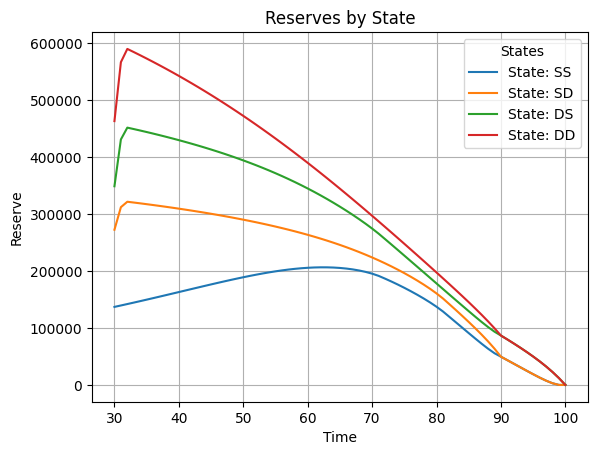

SS 0
SD 1
DS 6
DD 7


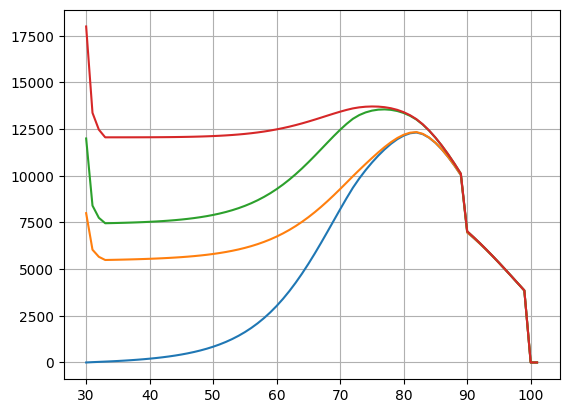

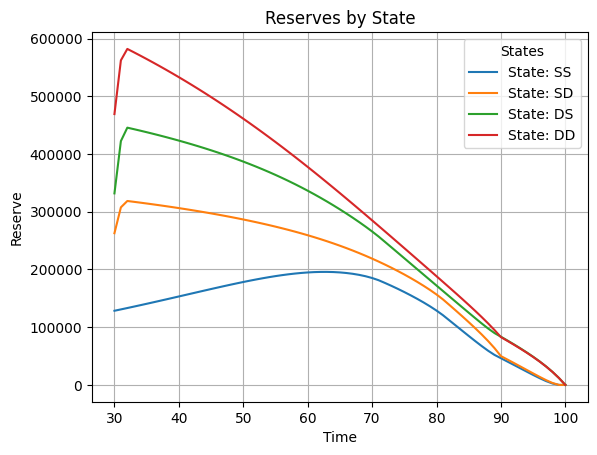

SS 0
SD 1
DS 6
DD 7


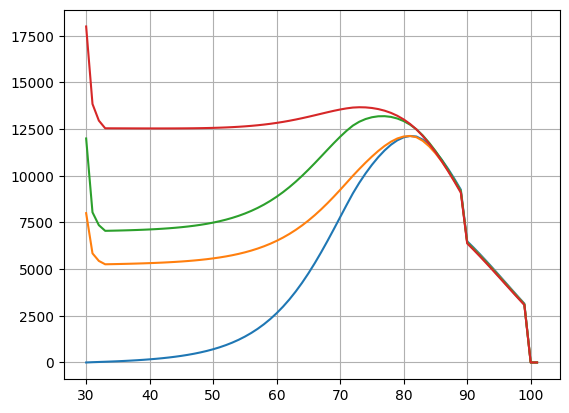

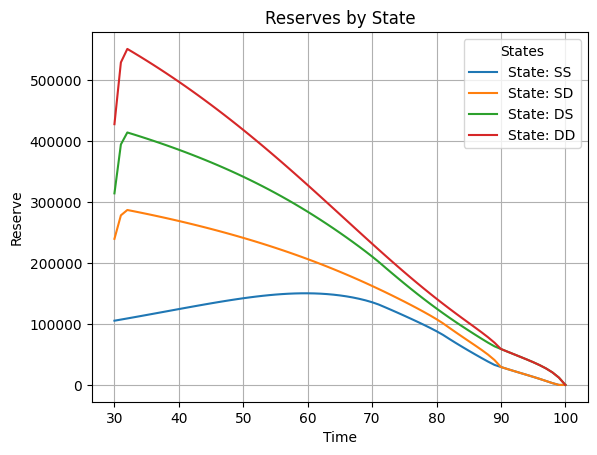

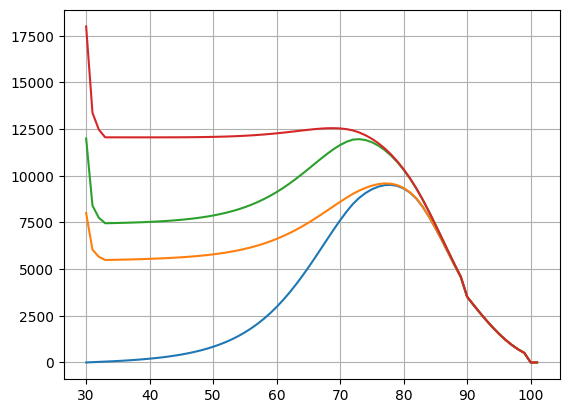

In [249]:
## RUN THIS TO READ THE TEXT LATER. HERE I DECLARE EVERYTHING AND SOME PLOTS ARE GENERATED (FORGET ABOUT THE PLOTS)


# STANDARD MODEL
Model_standard = Diab2Lifes(number_of_disability_states = 4)
Model_standard.vSetQx(Qx)
Model_standard.vSetIx(Ix)
Model_standard.vSetRx(Rx)

Model_standard.vSetGender(0,1)
Model_standard.vSetAges(30,40)
Model_standard.vSetBenefits(12000, 8000, 18000)

Model_standard.SetChanger(0)

Model_standard.vPopulatePij()
Model_standard.vPopulateApre()

Model_standard.vPlot(allSymb=["SS","SD","DS","DD"])


# MODEL WITH DEPENDANT PROBABILITIES
Model_Dependent_Probabilities = Diab2Lifes(number_of_disability_states = 4)
Model_Dependent_Probabilities.vSetQx(Qx)
Model_Dependent_Probabilities.vSetIx(Ix)
Model_Dependent_Probabilities.vSetRx(Rx)

Model_Dependent_Probabilities.vSetGender(0,1)
Model_Dependent_Probabilities.vSetAges(30,40)
Model_Dependent_Probabilities.vSetBenefits(12000, 8000, 18000)

Model_Dependent_Probabilities.SetChanger(1)

Model_Dependent_Probabilities.vPopulatePij()
Model_Dependent_Probabilities.vPopulateApre()

Model_Dependent_Probabilities.vPlot(allSymb=["SS","SD","DS","DD"])


# MODEL WITH NO REDUCTION IN MORTALITY (NoTrend)
Model_NoTrend = Diab2Lifes(number_of_disability_states = 4)
Model_NoTrend.vSetQx(QxNoTrend)
Model_NoTrend.vSetIx(Ix)
Model_NoTrend.vSetRx(Rx)

Model_NoTrend.vSetGender(0,1)
Model_NoTrend.vSetAges(30,40)
Model_NoTrend.vSetBenefits(12000, 8000, 18000)

Model_NoTrend.SetChanger(0)

Model_NoTrend.vPopulatePij()
Model_NoTrend.vPopulateApre()

Model_NoTrend.vPlot(allSymb=["SS","SD","DS","DD"])


def save_premium_for_selected_states(Model):
  premium = []

  print("SS -->", round(Model.dGetVx(30, "S", "S"), 2))
  premium.append(Model.dGetVx(30, "S", "S"))
  print("SD -->", round(Model.dGetVx(30, "S", "D"), 2))
  premium.append(Model.dGetVx(30, "S", "D"))
  print("DS -->", round(Model.dGetVx(30, "D", "S"), 2))
  premium.append(Model.dGetVx(30, "D", "S"))
  print("DD -->", round(Model.dGetVx(30, "D", "D"), 2))
  premium.append(Model.dGetVx(30, "D", "D"))
  print("S3 -->", round(Model.dGetVx(30, "S", 3), 2))
  premium.append(Model.dGetVx(30, "S", 3))
  print("33 -->", round(Model.dGetVx(30, 3, 3), 2))
  premium.append(Model.dGetVx(30, 3, 3))
  print("T3 -->", round(Model.dGetVx(30, "T", 3), 2))
  premium.append(Model.dGetVx(30, "T", 3))
  print("3T -->", round(Model.dGetVx(30, 3, "T"), 2))
  premium.append(Model.dGetVx(30, 3, "T"))
  print("TD -->", round(Model.dGetVx(30, "T", "D"), 2))
  premium.append(Model.dGetVx(30, "T", "D"))
  print("DT -->", round(Model.dGetVx(30, "D", "T"), 2))
  premium.append(Model.dGetVx(30, "D", "T"))
  return premium

# **Question 1**

What is the mathematics definition of stochastic independence for two random variables X and Y and what is the difference to uncorrelated? Does on imply the other?


**Stochastic Independence:** joint distribution of $(X,Y)$ equal to product of marginal distribution, i.e.**bold text**
$$
P[X=x, Y=y] = P[X=x]\cdot P[Y=y]
$$
We then have
$$
\mathbb{E}(XY) = \sum_i \sum_j x_i y_j f_{XY}(x_i, y_j) = \sum_i \sum_j x_i y_j f_X(x_i) f_Y(y_j) \\
= \left( \sum_i x_i f_X(x_i) \right) \left( \sum_j y_j f_Y(y_j) \right) = \mathbb{E}(X) \mathbb{E}(Y)
$$


**Uncorrelation:** $Cov(X,Y) = \mathbb{E}[(X-\mathbb{E}[X])(Y-\mathbb{E}[Y])]=0$

If $X$ and $Y$ are independent, then
\begin{align}
Cov(X,Y)  & = \mathbb{E}\big[(X-\mathbb{E}[X])(Y-\mathbb{E}[Y])\big] \\
          & = \mathbb{E}\big[ XY -\mathbb{E}[X] Y - X\mathbb{E}[Y] + \mathbb{E}[X]\mathbb{E}[Y]\big] \\
          & = \mathbb{E}[XY] - \mathbb{E}[X]\mathbb{E}[Y] - \mathbb{E}[X]\mathbb{E}[Y] + \mathbb{E}[X]\mathbb{E}[Y] \\
          & = \mathbb{E}[XY] - \mathbb{E}[X]\mathbb{E}[Y] \\
          & = 0
          \end{align}

The converse is not in general true. Consider $X$ be with $\mathbb{E}[X]=0$ and  $\mathbb{E}[X^3]=0$ and define $Y=X^2$ Then $X$ and $Y$ are dependent but at the same time
$$
Cov(X,Y) = \mathbb{E}[(X-\mathbb{E}[X])(Y-\mathbb{E}[Y])] = \mathbb{E}[0*(Y-\mathbb{E}[Y])] = 0
$$

# **Question 2: Independent probabilities**


SS 0
SD 1
DS 6
DD 7


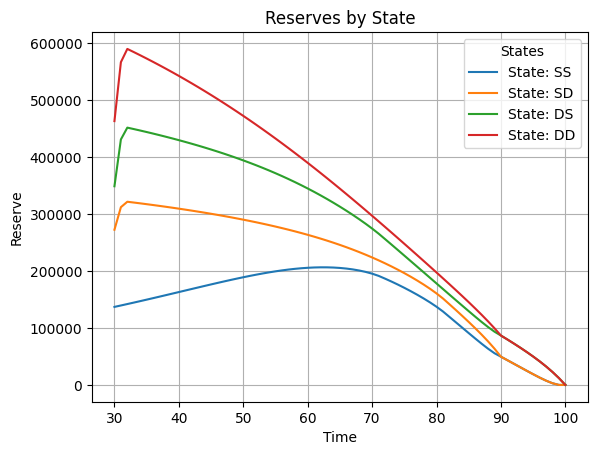

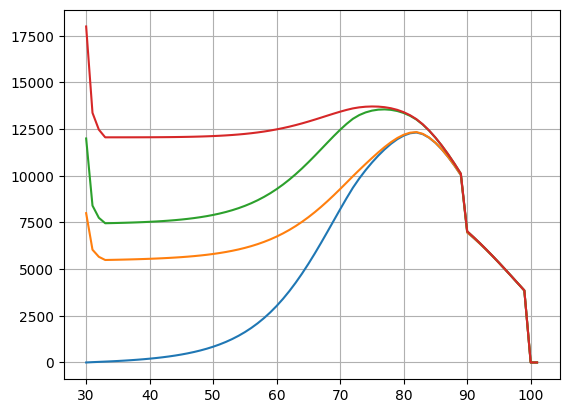

In [243]:
# Plot reserves and cash flows for selected states
Model_standard.vPlot(allSymb=["SS","SD","DS","DD"])

In [ ]:
print("The premiums for the standard model are")
save_premium_for_selected_states(Model_standard)
print(" ")

The premiums for the standard model are
SS --> 136862.84
SD --> 272188.21
DS --> 348471.91
DD --> 462740.44
S3 --> 330031.76
33 --> 615748.81
T3 --> 262791.31
3T --> 415502.71
TD --> 204479.42
DT --> 291682.04
 


# **Question 3: Dependent probabilities**

SS 0
SD 1
DS 6
DD 7


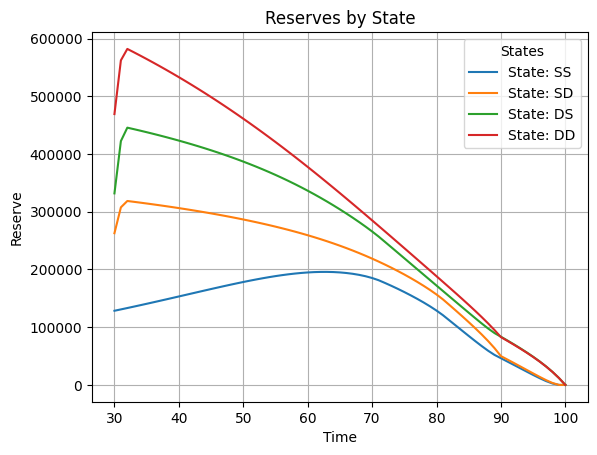

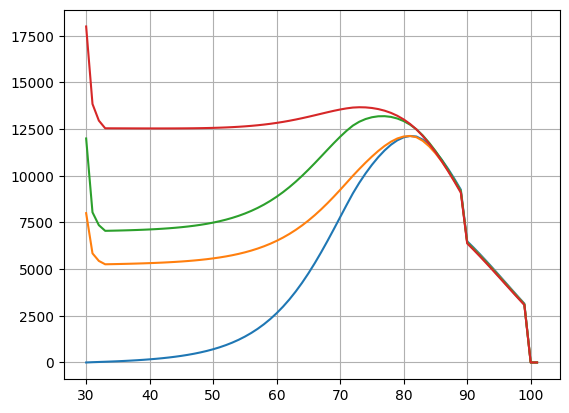

In [ ]:
# Plot reserves and cash flows for selected states
Model_Dependent_Probabilities.vPlot(allSymb=["SS","SD","DS","DD"])

In [ ]:
print("The premiums for the model with dependant probabilities are")
save_premium_for_selected_states(Model_Dependent_Probabilities)
print(" ")

The premiums for the model with dependant probabilities are
SS --> 128467.69
SD --> 262834.23
DS --> 331809.65
DD --> 469176.5
S3 --> 328241.05
33 --> 606898.09
T3 --> 259419.2
3T --> 408802.77
TD --> 223867.42
DT --> 332885.51
 


# **Question 4: Comparison dependence vs independence**

In [ ]:
x0 = 30
x = 40
y = 50
t = 2024 + x - x0 # 2034
rx0 = Rx(0, x, 0)
ry0 = Rx(0, y, 0)
rx1 = Rx(0, x, 1)
ry1 = Rx(0, y, 1)
qx = Qx(0, x, t)
qy = Qx(1, y, t)
ix = Ix(0, x, t)
iy = Ix(1, y, t)

## for the third line, to get the independent probabilities just remove the coefficients

print("-------(SS)->(TS)-------")
print("Independant:", round(Model_standard.Pij_2Life(0, 40, 1, 50, 2034, 0, 30, 0), 8))
print("Dependant:  ", round(Model_Dependent_Probabilities.Pij_2Life(0, 40, 1, 50, 2034, 0, 30, 0), 8))
print("Calculated: ", round(0.9 * qx * (1 - 0.9 * qy - 0.85 * iy), 8))
print(" ")

print("-------(TS)->(TT)-------")
print("Independant:", round(Model_standard.Pij_2Life(0, 40, 1, 50, 2034, 30, 35, 0), 8))
print("Dependant:  ", round(Model_Dependent_Probabilities.Pij_2Life(0, 40, 1, 50, 2034, 30, 35, 0), 8))
print("Calculated: ", round(1 * 1.1 * qy, 8))
print(" ")

print("-------(SS)->(SD)-------")
print("Independant:", round(Model_standard.Pij_2Life(0, 40, 1, 50, 2034, 0, 1, 0), 8))
print("Dependant:  ", round(Model_Dependent_Probabilities.Pij_2Life(0, 40, 1, 50, 2034, 0, 1, 0), 8))
print("Calculated: ", round((1 - 0.9 * qx - 0.85 * ix) * 0.85 * iy, 8))
print(" ")

print("-------(SD)->(D1)-------")
print("Independant:", round(Model_standard.Pij_2Life(0, 40, 1, 50, 2034, 1, 8, 0), 8))
print("Dependant:  ", round(Model_Dependent_Probabilities.Pij_2Life(0, 40, 1, 50, 2034, 1, 8, 0), 8))
print("Calculated: ", round(1.15 * ix * (1 - 1.1 * ry0 - 1.1 * qy), 8))
print(" ")

print("-------(D1)->(SS)-------")
print("Independant:", round(Model_standard.Pij_2Life(0, 40, 1, 50, 2034, 8, 0, 0), 8))
print("Dependant:  ", round(Model_Dependent_Probabilities.Pij_2Life(0, 40, 1, 50, 2034, 8, 0, 0), 8))
print("Calculated: ", round(0.9 * rx0 * 0.9 * ry1, 8))
print(" ")

print("-------(SS)->(SS)-------")
print("Independant:", round(Model_standard.Pij_2Life(0, 40, 1, 50, 2034, 0, 0, 0), 8))
print("Dependant:  ", round(Model_Dependent_Probabilities.Pij_2Life(0, 40, 1, 50, 2034, 0, 0, 0), 8))
print("Calculated: ", round((1 - 0.9 * qx - 0.85 * ix) * (1 - 0.9 * qy - 0.85 * iy), 8))



-------(SS)->(TS)-------
Independant: 0.0008233
Dependant:   0.00074145
Calculated:  0.00074145
 
-------(TS)->(TT)-------
Independant: 0.00060017
Dependant:   0.00066019
Calculated:  0.00066019
 
-------(SS)->(SD)-------
Independant: 0.00385925
Dependant:   0.00328127
Calculated:  0.00328127
 
-------(SD)->(D1)-------
Independant: 0.00102756
Dependant:   0.00115371
Calculated:  0.00115371
 
-------(D1)->(SS)-------
Independant: 0.01249587
Dependant:   0.01012165
Calculated:  0.01012165
 
-------(SS)->(SS)-------
Independant: 0.99344387
Dependant:   0.99435495
Calculated:  0.99435495


# **Question 5**


SS 0
SD 1
DS 6
DD 7


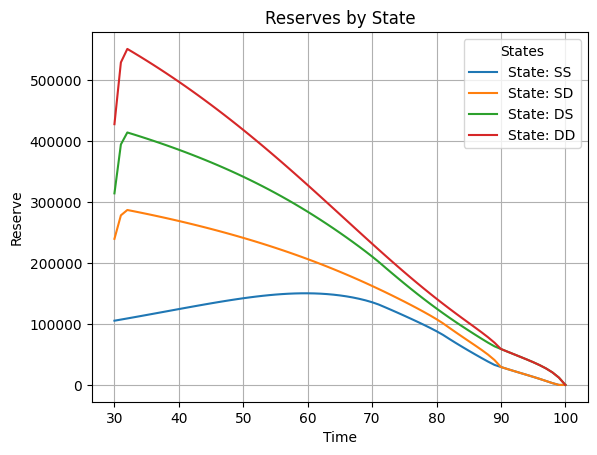

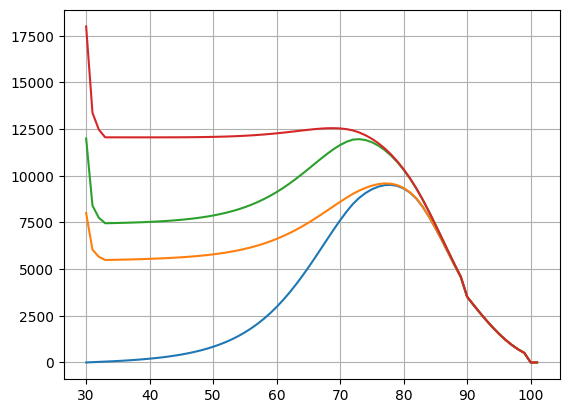

In [ ]:
# Plot reserves and cash flows for selected states
Model_NoTrend.vPlot(allSymb=["SS","SD","DS","DD"])

In [ ]:
print("The premiums for the model with no mortality reduction are")
save_premium_for_selected_states(Model_NoTrend)
print(" ")

The premiums for the model with no mortality reduction are
SS --> 105348.47
SD --> 239634.97
DS --> 314253.03
DD --> 427714.96
S3 --> 296998.09
33 --> 578900.19
T3 --> 248053.43
3T --> 389201.63
TD --> 190258.68
DT --> 267470.77
 


## **CHECKER PROBABILITIES**

In [ ]:
x0 = 30
delta = 10
x = 45
y = x + delta
t = 2024 + x - x0 # 2039

def Printer_probabilities(gender1, age1, gender2, age2, t, Model, Initial_State):
    partial = 0
    for i in range(36):
        prob = Model.Pij_2Life(gender1, age1, gender2, age2, t, Initial_State, i, 0)
        if np.abs(prob) > 0.00000000000001:
            partial += prob
            print(f"{Initial_State:<1} --> {i:<3} : {prob:>20.8f} {partial:>20.8f}")

print("Probabilities for SS with Dependant Model")
Printer_probabilities(0, x, 1, y, t, Model_Dependent_Probabilities, 0)
print("------------------------------------------------------")

print("Probabilities for DD with Dependant Model")
Printer_probabilities(0, x, 1, y, t, Model_Dependent_Probabilities, 7)
print("------------------------------------------------------")
print("------------------------------------------------------")
print("------------------------------------------------------")

print("Probabilities for SS with independent Model")
Printer_probabilities(0, x, 1, y, t, Model_standard, 0)
print("------------------------------------------------------")

print("Probabilities for DD with independent Model")
Printer_probabilities(0, x, 1, y, t, Model_standard, 7)

Probabilities for SS with Dependant Model
0 --> 0   :           0.99002753           0.99002753
0 --> 1   :           0.00620247           0.99623000
0 --> 5   :           0.00086098           0.99709098
0 --> 6   :           0.00180426           0.99889524
0 --> 7   :           0.00001130           0.99890654
0 --> 11  :           0.00000157           0.99890811
0 --> 30  :           0.00108416           0.99999226
0 --> 31  :           0.00000679           0.99999906
0 --> 35  :           0.00000094           1.00000000
------------------------------------------------------
Probabilities for DD with Dependant Model
7 --> 0   :           0.02891901           0.02891901
7 --> 2   :           0.16721855           0.19613756
7 --> 5   :           0.00022608           0.19636364
7 --> 12  :           0.11813931           0.31450295
7 --> 14  :           0.68311763           0.99762058
7 --> 17  :           0.00092357           0.99854414
7 --> 30  :           0.00021441           0.998758

## **Create premium matrix for comparison comments**

In [ ]:
premiums = np.zeros([10,3])
for i in range(3):
  if i == 0:
    temp_Model = Model_standard
  elif i == 1:
    temp_Model = Model_Dependent_Probabilities
  else:
    temp_Model = Model_NoTrend
  premiums[0,i] = round(temp_Model.dGetVx(30, "S", "S"), 2)
  premiums[1,i] = round(temp_Model.dGetVx(30, "S", "D"), 2)
  premiums[2,i] = round(temp_Model.dGetVx(30, "D", "S"), 2)
  premiums[3,i] = round(temp_Model.dGetVx(30, "S", 3), 2)
  premiums[4,i] = round(temp_Model.dGetVx(30, 3, "S"), 2)
  premiums[5,i] = round(temp_Model.dGetVx(30, 3, 3), 2)
  premiums[6,i] = round(temp_Model.dGetVx(30, "T", 3), 2)
  premiums[7,i] = round(temp_Model.dGetVx(30, 3, "T"), 2)
  premiums[8,i] = round(temp_Model.dGetVx(30, "T", "D"), 2)
  premiums[9,i] = round(temp_Model.dGetVx(30, "D", "T"), 2)

# First columns is stdModel, third column is no_trend and second column is Dependant probabilities
# first row: SS
# second row: SD
# third row: DS
# fourth row: S3
# fifth row: 3S
# sixth row: 33
# seventh row: T3
# eighth row: 3T
# ninth row: TD
# tenth row: DT
#print(premiums)

premiums_std = premiums[:,0]
premiums_dependant = premiums[:,1]
premiums_no_trend = premiums[:,2]

print("premium difference between indep and dep probabilities", premiums_dependant - premiums_std)
print("premium difference between indep and no trend", premiums_no_trend - premiums_std)
print(" ")

diff1 = np.abs(premiums_dependant - premiums_std)
diff2 = np.abs(premiums_no_trend - premiums_std)

max_position = np.argmax(diff1)
max_position
print("biggest difference in premium between indep and dep model at state",max_position,"with difference of",  round(diff1[max_position],2))
max_position = np.argmax(diff2)
max_position
print("biggest difference in premium between indep and no trend model", max_position,"with difference of", round(diff2[max_position],2))


premium difference between indep and dep probabilities [ -8395.15  -9353.98 -16662.26  -1790.71  -4094.66  -8850.72  -3372.11
  -6699.94  19388.    41203.47]
premium difference between indep and no trend [-31514.37 -32553.24 -34218.88 -33033.67 -35877.33 -36848.62 -14737.88
 -26301.08 -14220.74 -24211.27]
 
biggest difference in premium between indep and dep model at state 9 with difference of 41203.47
biggest difference in premium between indep and no trend model 5 with difference of 36848.62


**Comments:**

1.   One can notice that the price for the policies is smaller when considering the NoTrend mortality wrt to the generational mortality (see vector diff2 above) In my opinion this is due to the fact that with the generational mortality the lifespan is much higher. Hence, in case of disability the total payout is much greater. In the model with NoTrend, no change in disability rates and reactivation is made, ensuring that the only difference between the two models is indeed the lifespan.
One can see at ages 85-90 (for the male) that there are two "convergence barrier, one for the std_case and one for the no_trend case. The difference in height (i.e. in cash flow) is again imo for the longer longevity of the std/generational model.
[See Graph below]

2. The biggest difference in premium between the std model and no_trend model is at state 33, namely both people in the absorbing state of disability. This is in line with point1 due to the difference in lifespan. The couple cannot reactivate (not even the single person) and therefore the benefit is until death or 100y. Hence, using the generational table will increase the theoretical lifespan of the couple and increase the price of the policy when compared to the no_trend case. In general, the cases SS, SD, DS, S3, 3S and 33 have the highest premium difference. The other cases are when one person is dead, hence the difference is not that big as compared to the first cases.


3.   From the results that I got, the biggest difference in price bewteen the standard model and the dependant model is when the starting states are TD and DT. In this case the mortality the reactivation is decreased by 40%. In this case, for the disabled widower is really difficult to reactivate, hence the higher price. We also have to notice that the mortality is also 20% higher, reducing then the years of possible payout. The latter effect is IMO completely overturned by the decrease in reactivation probability.

4. We see for instance that in the case SS, the dependent model has a much smaller price (8k difference) because the mortality and invalidity probability are scaler in favour of staying in the state S for both people.  





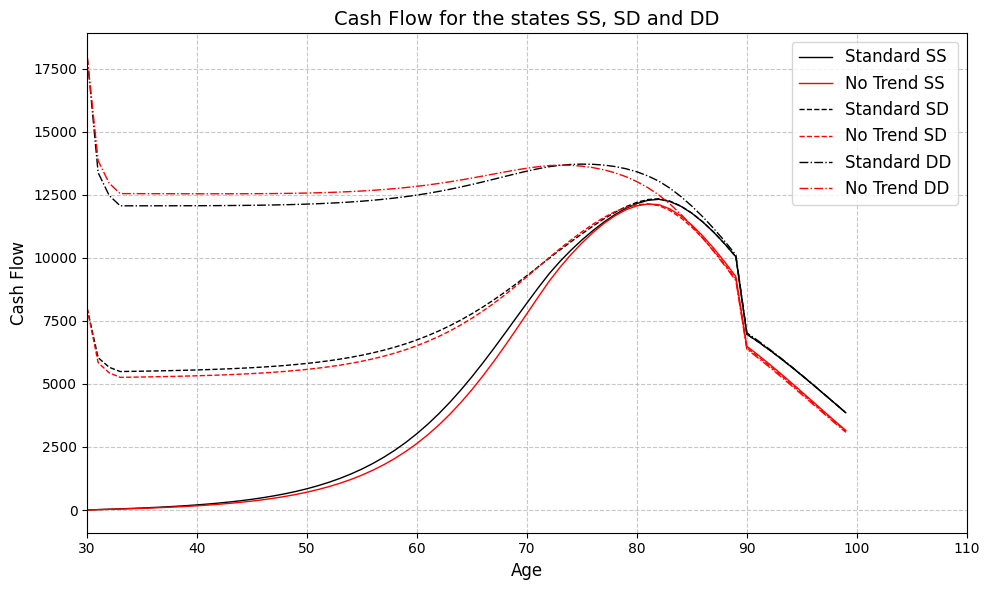

In [ ]:
# SS = 0
# SD = 1
# DS = 6
# DD = 7

x = range(30, 100)  # X-axis values from 0 to 120
SS1 = [Model_standard.dCF[i][0] for i in x]
SS2 = [Model_Dependent_Probabilities.dCF[i][0] for i in x]
SS3 = [Model_NoTrend.dCF[i][0] for i in x]

SD1 = [Model_standard.dCF[i][1] for i in x]
SD2 = [Model_Dependent_Probabilities.dCF[i][1] for i in x]
SD3 = [Model_NoTrend.dCF[i][1] for i in x]

DD1 = [Model_standard.dCF[i][7] for i in x]
DD2 = [Model_Dependent_Probabilities.dCF[i][7] for i in x]
DD3 = [Model_NoTrend.dCF[i][7] for i in x]

# Create the plot
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(x, SS1, label='Standard SS', color='black', linestyle='-', linewidth=1)
plt.plot(x, SS2, label='No Trend SS', color='red', linestyle='-', linewidth=1)
#plt.plot(x, SS3, label='Dependant', color='blue', linestyle='-', linewidth=1)
plt.plot(x, SD1, label='Standard SD', color='black', linestyle='--', linewidth=1)
plt.plot(x, SD2, label='No Trend SD', color='red', linestyle='--', linewidth=1)
#plt.plot(x, SD3, label='Dependant', color='blue', linestyle='--', linewidth=1)
plt.plot(x, DD1, label='Standard DD', color='black', linestyle='-.', linewidth=1)
plt.plot(x, DD2, label='No Trend DD', color='red', linestyle='-.', linewidth=1)
#plt.plot(x, DD3, label='Dependant', color='blue', linestyle='-.', linewidth=1)

# Customize the plot
plt.title('Cash Flow for the states SS, SD and DD', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Cash Flow', fontsize=12)
plt.xlim(30, 110)  # Set X-axis range
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()
#for x in range (30,100):
  #print(x, x+model6.y0-model6.x0, model6.dCF[x][stato])

# **Question 6: Number of disability states**

Plotting for Model4...
SS 0
SD 1
DS 6
DD 7


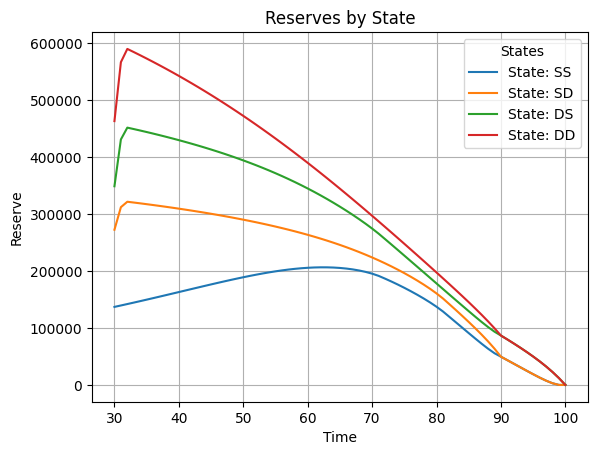

Plotted successfully
4 136862.83797151875
Plotting for Model5...
SS 0
SD 1
DS 7
DD 8


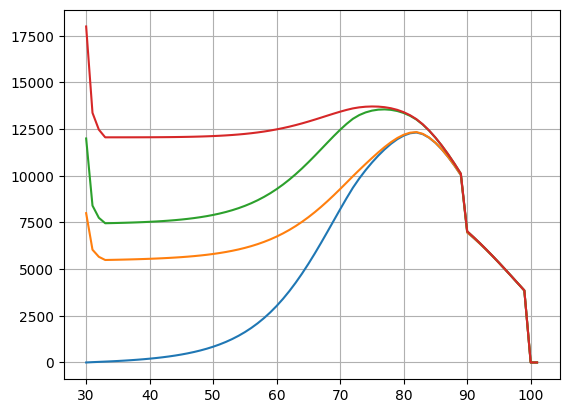

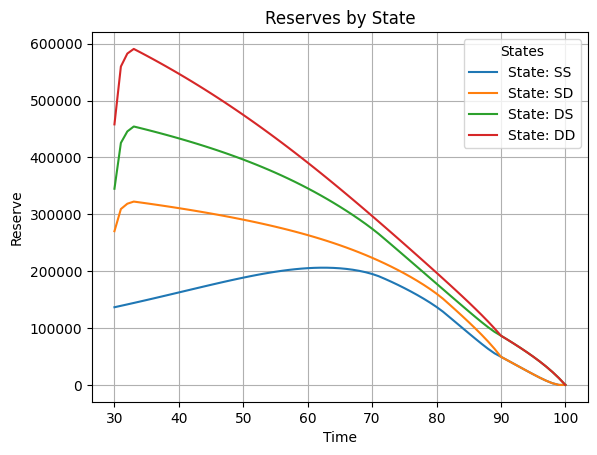

Plotted successfully
5 136614.29117368083
Plotting for Model6...
SS 0
SD 1
DS 8
DD 9


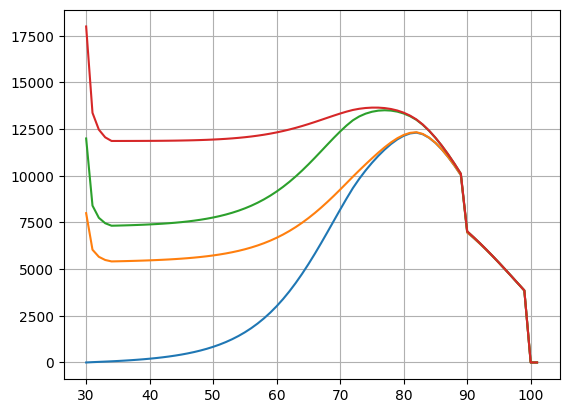

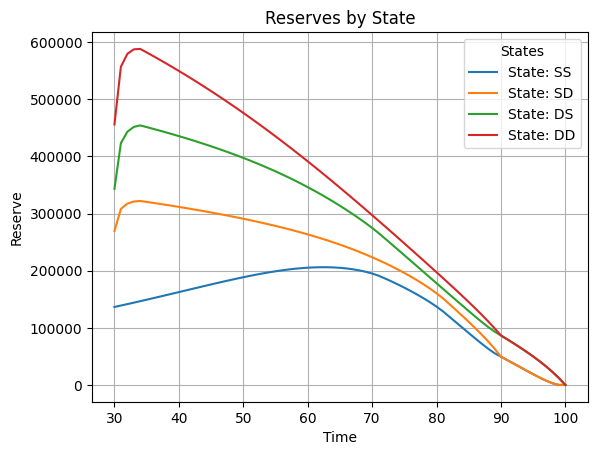

Plotted successfully
6 136506.19339029957
Plotting for Model7...
SS 0
SD 1
DS 9
DD 10


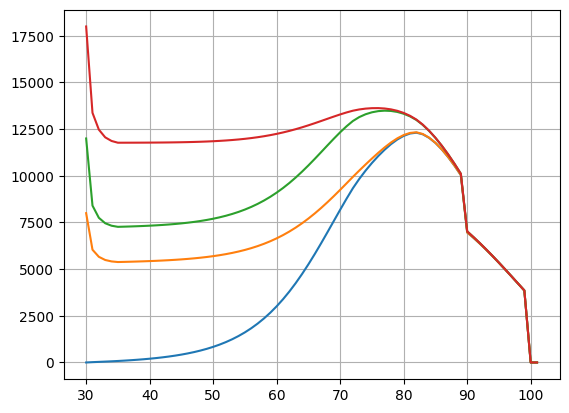

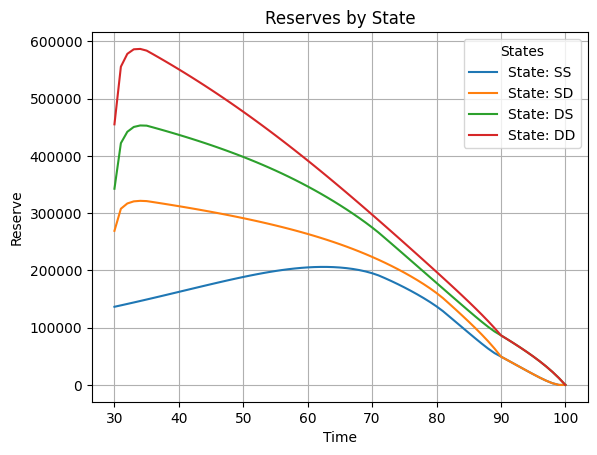

Plotted successfully
7 136459.09600374888
Plotting for Model8...
SS 0
SD 1
DS 10
DD 11


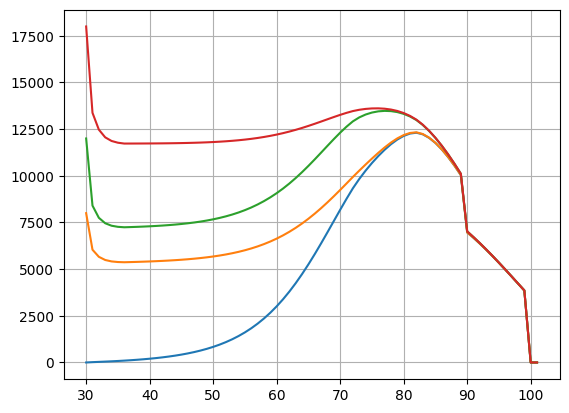

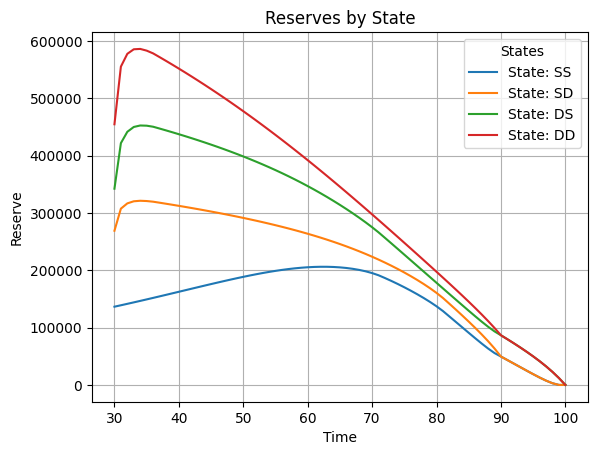

Plotted successfully
8 136438.57840031723
Plotting for Model9...
SS 0
SD 1
DS 11
DD 12


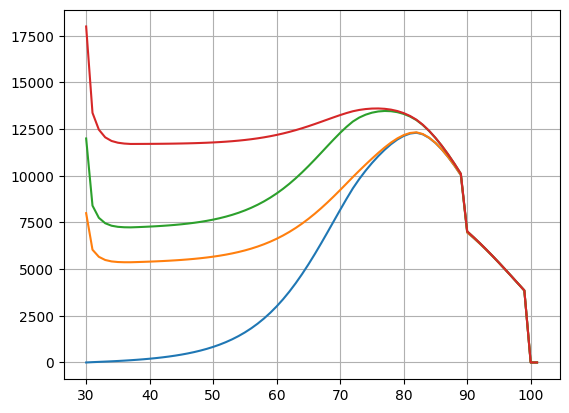

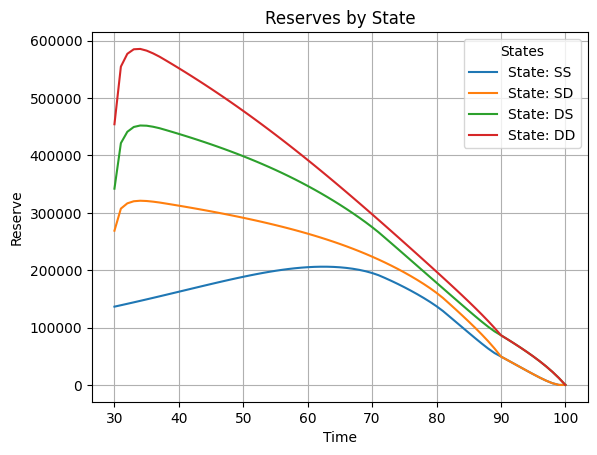

Plotted successfully
9 136429.6492548397
Plotting for Model10...
SS 0
SD 1
DS 12
DD 13


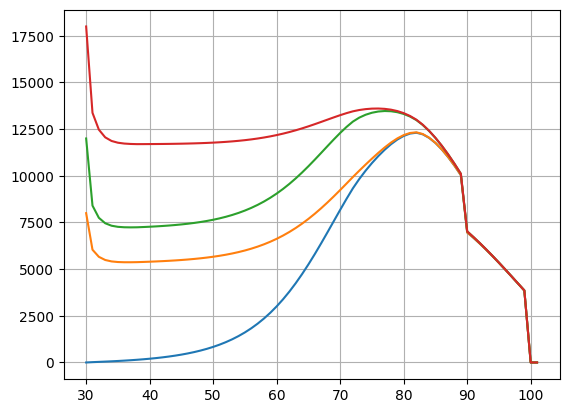

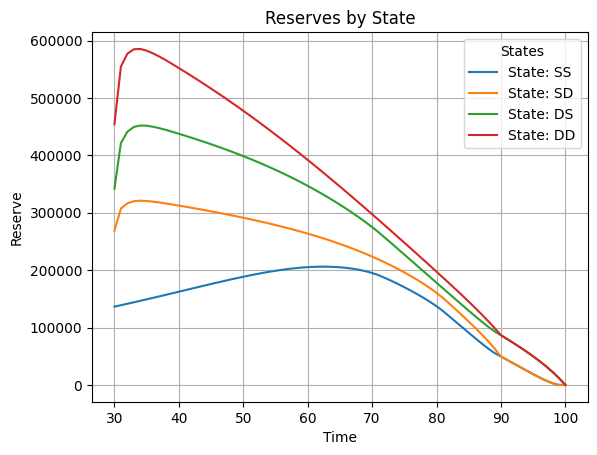

Plotted successfully
10 136425.76899079527


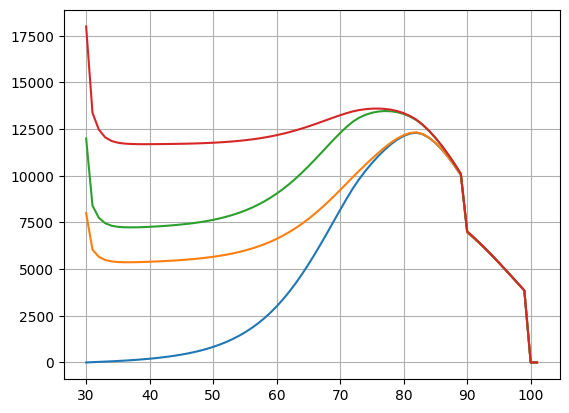

In [ ]:
models_params = [
    {"name": "Model4", "number_of_disability_states": 4},
    {"name": "Model5", "number_of_disability_states": 5},
    {"name": "Model6", "number_of_disability_states": 6},
    {"name": "Model7", "number_of_disability_states": 7},
    {"name": "Model8", "number_of_disability_states": 8},
    {"name": "Model9", "number_of_disability_states": 9},
    {"name": "Model10", "number_of_disability_states": 10},
]

models = {}
error = 1
temp_prev = 1
for params in models_params:
    model_name = params["name"]
    num_disability_states = params["number_of_disability_states"]
    if np.abs(error) > 0.5/100:
      # Create the model instance
      model = Diab2Lifes(number_of_disability_states=num_disability_states)

      # Set the necessary properties
      model.vSetQx(Qx)
      model.vSetIx(Ix)
      model.vSetRx(Rx)
      model.vSetGender(0, 1)  # Gender settings (example: 0 = Male, 1 = Female)
      model.vSetAges(30, 40)  # Ages for the two lives
      model.vSetBenefits(12000, 8000, 18000)  # Benefits for the models
      model.SetChanger(0)  # Optional: Set specific behavioral toggles

      # Populate matrices and values
      model.vPopulatePij()
      model.vPopulateApre()

      # Store the model for later reference
      models[model_name] = model

      # Plot the results for the current model
      print(f"Plotting for {model_name}...")
      model.vPlot(allSymb=["SS","SD","DS","DD"])
      print(f"Plotted successfully")
      temp_new = model.dGetVx(30, "S", "S")
      #print("temp_prev", temp_prev)
      #print("temp_new", temp_new)
      error = temp_new/temp_prev-1
      #print("error", error)
      temp_prev = temp_new
      #print("temp_prev", temp_prev)
      error = 1
      print(num_disability_states, model.dGetVx(30, "S", "S"))


Plotting for Model11...
SS 0
SD 1
DS 13
DD 14


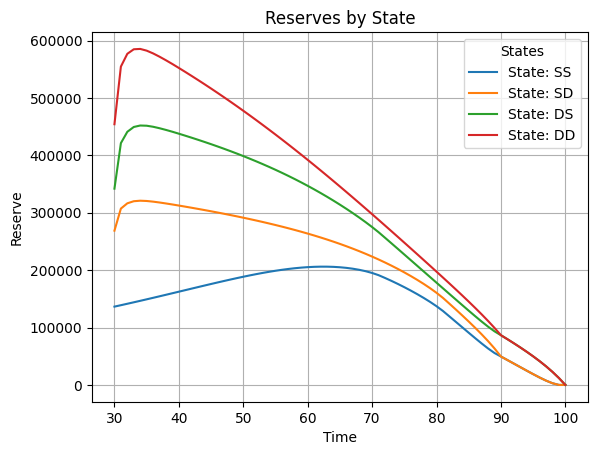

Plotted successfully
11 136424.08554574178
Plotting for Model12...
SS 0
SD 1
DS 14
DD 15


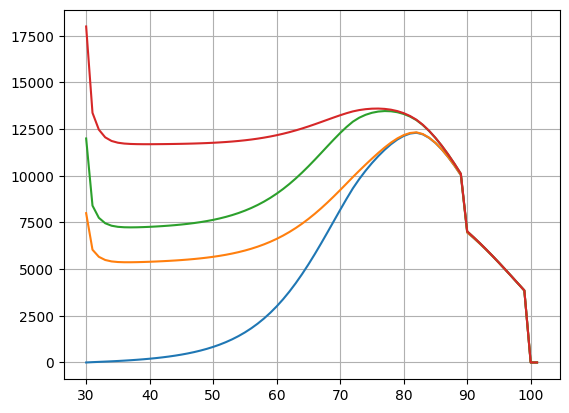

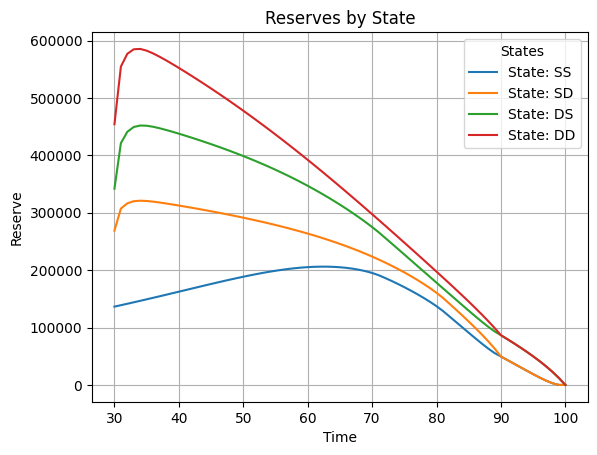

Plotted successfully
12 136423.35644070315


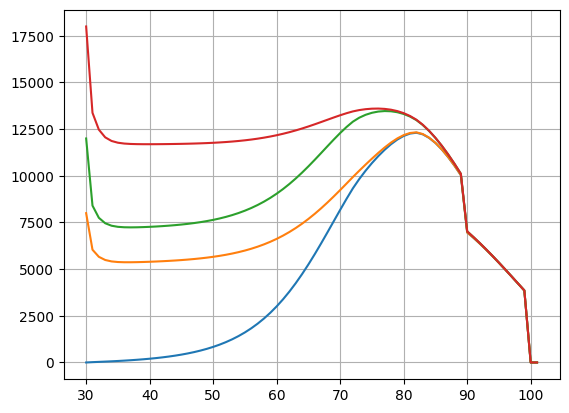

In [ ]:
models_params2 = [
    {"name": "Model11", "number_of_disability_states": 11},
    {"name": "Model12", "number_of_disability_states": 12},
    #{"name": "Model13", "number_of_disability_states": 13},
    #{"name": "Model7", "number_of_disability_states": 7},
    #{"name": "Model8", "number_of_disability_states": 8},
    #{"name": "Model9", "number_of_disability_states": 9},
    #{"name": "Model10", "number_of_disability_states": 10},
]

models2 = {}
error = 1
temp_prev = 1
for params in models_params2:
    model_name = params["name"]
    num_disability_states = params["number_of_disability_states"]
    if np.abs(error) > 0.5/100:
      # Create the model instance
      model = Diab2Lifes(number_of_disability_states=num_disability_states)

      # Set the necessary properties
      model.vSetQx(Qx)
      model.vSetIx(Ix)
      model.vSetRx(Rx)
      model.vSetGender(0, 1)  # Gender settings (example: 0 = Male, 1 = Female)
      model.vSetAges(30, 40)  # Ages for the two lives
      model.vSetBenefits(12000, 8000, 18000)  # Benefits for the models
      model.SetChanger(0)  # Optional: Set specific behavioral toggles

      # Populate matrices and values
      model.vPopulatePij()
      model.vPopulateApre()

      # Store the model for later reference
      models2[model_name] = model

      # Plot the results for the current model
      print(f"Plotting for {model_name}...")
      model.vPlot(allSymb=["SS","SD","DS","DD"])
      print(f"Plotted successfully")
      temp_new = model.dGetVx(30, "S", "S")
      #print("temp_prev", temp_prev)
      #print("temp_new", temp_new)
      error = temp_new/temp_prev-1
      #print("error", error)
      temp_prev = temp_new
      #print("temp_prev", temp_prev)
      error = 1
      print(num_disability_states, model.dGetVx(30, "S", "S"))


In [ ]:
model4 = models["Model4"]
model5 = models["Model5"]
model6 = models["Model6"]
model7 = models["Model7"]
model8 = models["Model8"]
model9 = models["Model9"]
model10 = models["Model10"]
model11 = models2["Model11"]
model12 = models2["Model12"]

print(f"{'N. dis. states':<20} {'Benefit Value':>15}")
print(f"{'4:':<20} {round(model4.dGetVx(30, 'S', 'S'), 2):>15.2f}")
print(f"{'5:':<20} {round(model5.dGetVx(30, 'S', 'S'), 2):>15.2f}")
print(f"{'6:':<20} {round(model6.dGetVx(30, 'S', 'S'), 2):>15.2f}")
print(f"{'7:':<20} {round(model7.dGetVx(30, 'S', 'S'), 2):>15.2f}")
print(f"{'8:':<20} {round(model8.dGetVx(30, 'S', 'S'), 2):>15.2f}")
print(f"{'9:':<20} {round(model9.dGetVx(30, 'S', 'S'), 2):>15.2f}")
print(f"{'10:':<20} {round(model10.dGetVx(30, 'S', 'S'), 2):>15.2f}")
print(f"{'11:':<20} {round(model11.dGetVx(30, 'S', 'S'), 2):>15.2f}")
print(f"{'12:':<20} {round(model12.dGetVx(30, 'S', 'S'), 2):>15.2f}")

N. dis. states         Benefit Value
4:                         136862.84
5:                         136614.29
6:                         136506.19
7:                         136459.10
8:                         136438.58
9:                         136429.65
10:                        136425.77
11:                        136424.09
12:                        136423.36


In [ ]:
print("Number of disability states: 4")
premium4 = save_premium_for_selected_states(model4)
print(" ")

print("Number of disability states: 5")
premium5 = save_premium_for_selected_states(model5)
print(" ")

print("Number of disability states: 6")
premium6 = save_premium_for_selected_states(model6)
print(" ")

print("Number of disability states: 7")
premium7 = save_premium_for_selected_states(model7)
print(" ")

print("Number of disability states: 8")
premium8 = save_premium_for_selected_states(model8)
print(" ")

print("Number of disability states: 9")
premium9 = save_premium_for_selected_states(model9)
print(" ")

print("Number of disability states: 10")
premium10 = save_premium_for_selected_states(model10)
print(" ")

print("Number of disability states: 11")
premium11 = save_premium_for_selected_states(model11)
print(" ")

print("Number of disability states: 12")
premium12 = save_premium_for_selected_states(model12)
print(" ")
premium_limit = premium12

Number of disability states: 4
SS --> 136862.84
SD --> 272188.21
DS --> 348471.91
DD --> 462740.44
S3 --> 330031.76
33 --> 615748.81
T3 --> 262791.31
3T --> 415502.71
TD --> 204479.42
DT --> 291682.04
 
Number of disability states: 5
SS --> 136614.29
SD --> 270318.79
DS --> 344967.64
DD --> 458158.41
S3 --> 326866.96
33 --> 607904.63
T3 --> 259731.71
3T --> 408916.19
TD --> 202725.65
DT --> 288164.89
 
Number of disability states: 6
SS --> 136506.19
SD --> 269462.93
DS --> 343349.0
DD --> 456038.5
S3 --> 325409.79
33 --> 604257.61
T3 --> 258319.51
3T --> 405857.4
TD --> 201919.67
DT --> 286535.78
 
Number of disability states: 7
SS --> 136459.1
SD --> 269068.87
DS --> 342595.23
DD --> 455051.12
S3 --> 324734.49
33 --> 602550.22
T3 --> 257663.37
3T --> 404423.97
TD --> 201547.12
DT --> 285774.89
 
Number of disability states: 8
SS --> 136438.58
SD --> 268887.07
DS --> 342242.99
DD --> 454590.01
S3 --> 324420.75
33 --> 601748.62
T3 --> 257357.77
3T --> 403749.57
TD --> 201374.58
DT --> 2

If we assume that the Model12, namely the one with 12 total disability states (i.e. 11 non-absorbing states), then the first model for which for this selected starting states there's an error of at most 0.5% is the Model7. So 6 non-absorbing states are sufficient.

One should implement a way to check all initial states. The issue is that by adding a disability states, between two models the state are not the same. I didn't have the time to do this.

In [ ]:
for i in range(10):
  print(premium6[i] < (1+0.5/100)*premium12[i])

print(" ")

for i in range(10):
  print(premium7[i] < (1+0.5/100)*premium12[i])

True
True
True
True
True
False
True
False
True
True
 
True
True
True
True
True
True
True
True
True
True
